# IMPORT LIBRARIES

In [16]:
import pandas as pd
import numpy as np
import sys
import os
import random
from pathlib import Path

# Image processing
import imageio
import cv2
import skimage.transform


# Charts
import matplotlib.pyplot as plt
import seaborn as sns

# ML, statistics
import scipy
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import confusion_matrix, roc_curve, auc, roc_auc_score, ConfusionMatrixDisplay

# Tensorflow
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Input, Conv2D, Dense, Flatten, Dropout, Activation, BatchNormalization, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras import backend as K

# SETTINGS

## Global

In [17]:
# Settings
plt.style.use('fivethirtyeight')
#plt.style.use('seaborn')

# toy=True - development mode, small samples, limited training, fast run
# toy=False - full data, slow learning and run
toy=False

#set size of validation set and test set in percentage
validation_size = 10
test_size = 10

# Generators Paramenters
batch_size = 32
img_size = (224,224)

## Dataset Parameters

In [18]:
# Dataset Root Path
dataset_path = "../input/covid19-radiography-database/COVID-19_Radiography_Dataset"

# Folder Paths
covid_path = dataset_path + "/COVID"
lungOpacity_path = dataset_path + "/Lung_Opacity"
normal_path = dataset_path + "/Normal"
viralPneumonia_path = dataset_path + "/Viral Pneumonia"

# LABELS LOCAL Array
#labels = ['COVID', 'Lung Opacity', 'Normal', 'Viral Pneumonia']
labels = ['COVID', 'Normal', 'Viral Pneumonia']

# DATA PREPARATION

In [19]:
# Generate Filename list
def filename_list():

    if toy :
        random.seed(100)
        filenames = random.sample(os.listdir(covid_path), 200) + random.sample(os.listdir(lungOpacity_path), 200) + random.sample(os.listdir(normal_path), 200) + random.sample(os.listdir(viralPneumonia_path), 200)
    else :
       #filenames = os.listdir(covid_path) + os.listdir(lungOpacity_path) + os.listdir(normal_path) + os.listdir(viralPneumonia_path)
        filenames = os.listdir(covid_path) + os.listdir(normal_path) + os.listdir(viralPneumonia_path)

    return filenames

In [20]:
def dataframe_generation(files):
    
    categories = []
    for filename in files:
        category = filename.split('-')[0]
        if category == labels[0]:
            categories.append(str(0))
        elif category == labels[1]:
            categories.append(str(1))
        elif category == labels[2]:
            categories.append(str(2))
        #elif category == labels[3]:
         #   categories.append(str(3))

    for i in range(len(files)):
        if labels[0] in files[i]:
            files[i] = os.path.join(covid_path, files[i])
        #elif labels[1] in files[i]:
            #files[i] = os.path.join(lungOpacity_path, files[i])
        elif labels[1] in files[i]:
            files[i] = os.path.join(normal_path, files[i])
        elif labels[2] in files[i]:
            files[i] = os.path.join(viralPneumonia_path, files[i])
    
    df = pd.DataFrame({
        'filename': files,
        'category': categories
    })

    return df

## Generate Dataset

In [21]:
filenames = filename_list()
dataset_df = dataframe_generation(filenames)

dataset_df.head()

,filename,category
0,../input/covid19-radiography-database/COVID-19...,0
1,../input/covid19-radiography-database/COVID-19...,0
2,../input/covid19-radiography-database/COVID-19...,0
3,../input/covid19-radiography-database/COVID-19...,0
4,../input/covid19-radiography-database/COVID-19...,0


In [22]:
def read_img(id):
    """
    Read image by it's id
    """
    file=id
    im=cv2.imread(file)
    return im

def draw_sample_images(dataframe, ncols, labels):

        ncols=ncols
        n_rows = len(labels)

        f, ax = plt.subplots(nrows=n_rows,ncols=ncols, 
                             figsize=(4*ncols,5*2))
        i=-1
        captions=labels
        
        for label in range(n_rows):
            i=i+1
            samples = dataframe[dataframe["category"].astype(int) == label].filename.sample(ncols).values
            for j in range(0,ncols):
                file_id=samples[j]
                im=read_img(file_id)
                ax[i, j].imshow(im)
                ax[i, j].set_title(captions[i], fontsize=16)  
        plt.tight_layout()
        plt.show()

In [23]:
def plot_data_distribution(dataframe):
    dataframe.category.value_counts().plot(kind='bar')
    plt.title('Dataset Distribution')
    plt.xlabel('Label')
    plt.ylabel('Count')
    plt.show()

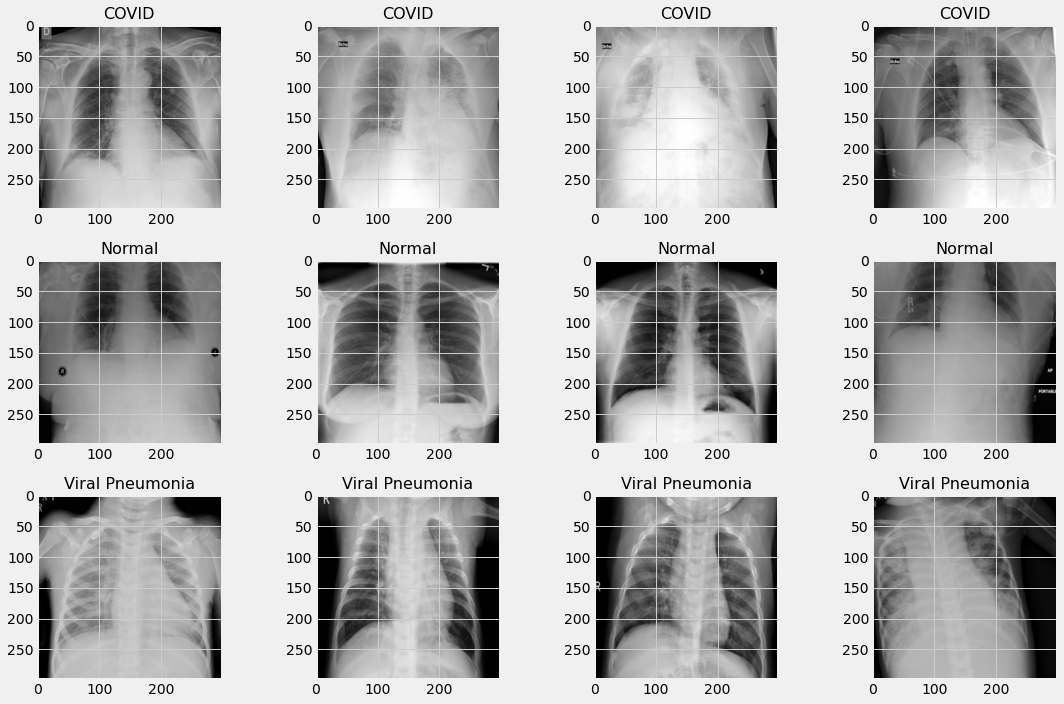

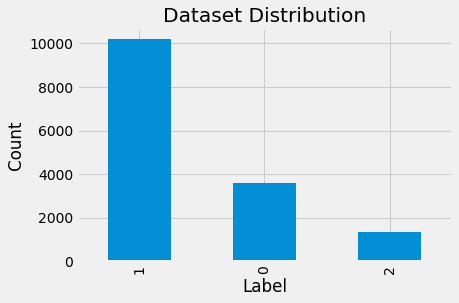

In [24]:
draw_sample_images(dataset_df, 4, labels)
plot_data_distribution(dataset_df)

## Dataset Balancing

In [25]:
def data_reduction(size):
    random.seed(100)
    reduced_dataset = random.sample(os.listdir(covid_path), size) + random.sample(os.listdir(normal_path), size) + random.sample(os.listdir(viralPneumonia_path), size)

    df_reduced = dataframe_generation(reduced_dataset)

    return df_reduced

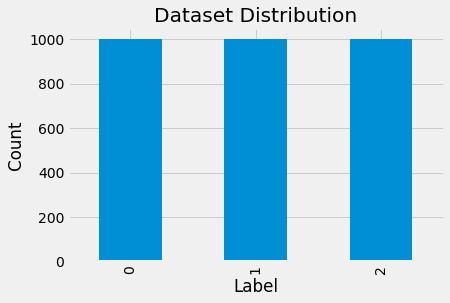

In [26]:
df_Reduced = data_reduction(1000)
plot_data_distribution(df_Reduced)

## Split in Train, Validation and Test

In [27]:
def sets_split(dataframe):
    x_1_split = (validation_size + test_size)/100
    x_2_split = round(test_size / (validation_size + test_size), 2)

    train_df, valTest_df = train_test_split(dataframe, test_size=x_1_split, random_state=24, shuffle=True, stratify=dataframe['category'])
    val_df, test_df = train_test_split(valTest_df, test_size=x_2_split, random_state=24, shuffle=True, stratify=valTest_df['category'])

    return train_df, val_df, test_df

In [28]:
train, validation, test = sets_split(dataset_df)

## Generators

In [29]:
_datagen = ImageDataGenerator(

            rotation_range=15,
            rescale=1./255,
            shear_range=0.1,
            zoom_range=0.2,
            horizontal_flip=True,
            width_shift_range=0.1,
            height_shift_range=0.1
            )

In [30]:
train_generator = _datagen.flow_from_dataframe(
            dataframe=train,
            x_col="filename",
            y_col="category",
            batch_size=batch_size,
            seed=123,
            shuffle=True,
            class_mode="categorical",
            color_mode="rgb",
            target_size=img_size)
print('Train generator created')

Found 12122 validated image filenames belonging to 3 classes.
Train generator created


In [31]:
val_generator = _datagen.flow_from_dataframe(
            dataframe=validation,
            x_col="filename",
            y_col="category",
            batch_size=batch_size,
            seed=123,
            shuffle=True,
            class_mode="categorical",
            color_mode="rgb",
            target_size=img_size)    
print('Validation generator created')

Found 1515 validated image filenames belonging to 3 classes.
Validation generator created


In [32]:
_test_datagen=ImageDataGenerator(rescale=1./255)

test_generator = _test_datagen.flow_from_dataframe(
            dataframe=test,
            x_col="filename",
            y_col=None,
            class_mode=None,
            batch_size=batch_size,
            seed=42,
            shuffle=False,
            color_mode="rgb",
            target_size=img_size)     
print('Test generator created')

Found 1516 validated image filenames.
Test generator created


# MODEL GENERATION

## Metrics aux Functions

In [33]:
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

## Model Creation

In [34]:
def create_model(size):
        base_model = ResNet50(input_shape= (size,size,3), include_top=False)

        x=base_model.output
        x=GlobalAveragePooling2D()(x)
        x = Dense(128, activation='relu')(x)
        x = Dense(64, activation='relu')(x)
        out=Dense(3,activation='softmax')(x)

        model=Model(inputs=base_model.input,outputs=out) 
            
        model.compile(optimizer= Adam(0.0001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy', f1_m, precision_m, recall_m])
        
        return model

In [35]:
model = create_model(224)
model.summary()

2022-03-15 16:17:58.332806: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-15 16:17:58.497132: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-15 16:17:58.498477: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-15 16:17:58.501025: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

94781440/94765736 [==============================] - 1s 0us/step
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
_____________________________

## Define Trainer

In [36]:
def train(model, train_data, val_data, toy):
        """
        Train the model
        """
        if toy:
            epochs=3

        else:
            epochs=100
            
        # We'll stop training if no improvement after some epochs
        earlystopper = EarlyStopping(monitor='val_loss', mode='min', patience=5 , restore_best_weights=True)

        # Save the best model during the traning
        checkpointer = ModelCheckpoint('best_model1.h5'
                                        ,monitor='val_loss'
                                        ,mode='min'
                                        ,verbose=1
                                        ,save_best_only=True)
        # Train
        training = model.fit(train_data, 
                            validation_data = val_data, 
                            epochs = epochs, 
                            verbose = 1,
                            batch_size = batch_size,
                            callbacks=[earlystopper, checkpointer])
        
        print("Trained")
                            
        return training

In [37]:
trained = train(model, train_generator, val_generator, toy)

2022-03-15 16:18:04.905386: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/100


2022-03-15 16:18:13.576240: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


379/379 [==============================] - 286s 716ms/step - loss: 0.1850 - accuracy: 0.9324 - f1_m: 0.9311 - precision_m: 0.9359 - recall_m: 0.9271 - val_loss: 0.9439 - val_accuracy: 0.6548 - val_f1_m: 0.6520 - val_precision_m: 0.6548 - val_recall_m: 0.6493

Epoch 00001: val_loss improved from inf to 0.94387, saving model to best_model1.h5


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/100
379/379 [==============================] - 211s 557ms/step - loss: 0.0907 - accuracy: 0.9676 - f1_m: 0.9675 - precision_m: 0.9681 - recall_m: 0.9670 - val_loss: 1.6356 - val_accuracy: 0.3347 - val_f1_m: 0.3326 - val_precision_m: 0.3346 - val_recall_m: 0.3306

Epoch 00002: val_loss did not improve from 0.94387
Epoch 3/100
379/379 [==============================] - 211s 557ms/step - loss: 0.0687 - accuracy: 0.9751 - f1_m: 0.9751 - precision_m: 0.9756 - recall_m: 0.9747 - val_loss: 1.2058 - val_accuracy: 0.5762 - val_f1_m: 0.5781 - val_precision_m: 0.5890 - val_recall_m: 0.5679

Epoch 00003: val_loss did not improve from 0.94387
Epoch 4/100
379/379 [==============================] - 209s 552ms/step - loss: 0.0656 - accuracy: 0.9752 - f1_m: 0.9752 - precision_m: 0.9756 - recall_m: 0.9748 - val_loss: 2.4440 - val_accuracy: 0.4059 - val_f1_m: 0.4040 - val_precision_m: 0.4059 - val_recall_m: 0.4022

Epoch 00004: val_loss did not improve from 0.94387
Epoch 5/100
379/379 [==========

# MODEL EVALUATION

## Generate Predictions

In [38]:
y_pred_raw = model.predict(test_generator)
y_pred = np.argmax(y_pred_raw, axis=1)
y_true = test.category.values
y_true=y_true[:len(y_pred)]

## Metrics Plot Functions

In [39]:
def plot_history(training):
        """
        Plot training history
        """
        ## Trained model analysis and evaluation
        f, ax = plt.subplots(1,2, figsize=(12,3))
        ax[0].plot(training.history['loss'], label="Loss")
        ax[0].plot(training.history['val_loss'], label="Validation loss")
        ax[0].set_title('Loss')
        ax[0].set_xlabel('Epoch')
        ax[0].set_ylabel('Loss')
        ax[0].legend()

        # Accuracy
        ax[1].plot(training.history['accuracy'], label="Accuracy")
        ax[1].plot(training.history['val_accuracy'], label="Validation accuracy")
        ax[1].set_title('Accuracy')
        ax[1].set_xlabel('Epoch')
        ax[1].set_ylabel('Accuracy')
        ax[1].legend()
        plt.tight_layout()
        plt.show()

def train_report(training):
    print("------- Training Report -----------")
    print("Accuracy: %0.2f" % (np.mean(training.history['accuracy'])*100))
    print("F1 Score: %0.2f" % (np.mean(training.history['f1_m'])*100))
    print("Precision: %0.2f" % (np.mean(training.history['precision_m'])*100))
    print("Recall: %0.2f" % (np.mean(training.history['recall_m'])*100))

    print("------- Validation Report -----------")
    print("Accuracy: %0.2f" % (np.mean(training.history['val_accuracy'])*100))
    print("F1 Score: %0.2f" % (np.mean(training.history['val_f1_m'])*100))
    print("Precision: %0.2f" % (np.mean(training.history['val_precision_m'])*100))
    print("Recall: %0.2f" % (np.mean(training.history['val_recall_m'])*100))

def print_report():
    """
    Predict and evaluate using ground truth from labels
    Test generator did not shuffle 
    and we can use true labels for comparison
    """
    #Print classification report
    print(metrics.classification_report(y_true, y_pred.astype(str), target_names = labels))
    
def print_conf_mtx():
    
    cm = confusion_matrix(y_true.astype(int), y_pred)

    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1,2])

    disp.plot(cmap=plt.cm.Blues)
    plt.show()

def multiclass_roc_auc_score(y_test, y_pred, average="weighted"):
    fig, c_ax = plt.subplots(1,1, figsize = (12, 8))
    lb = LabelBinarizer()
    lb.fit(y_test)
    y_test = lb.transform(y_test)
    y_pred = lb.transform(y_pred)

    for (idx, c_label) in enumerate(labels):
        fpr, tpr, thresholds = roc_curve(y_test[:,idx].astype(int), y_pred[:,idx])
        c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
        
    c_ax.plot(fpr, fpr, 'b-', label = 'Random Guessing')
    c_ax.legend()
    c_ax.set_xlabel('False Positive Rate')
    c_ax.set_ylabel('True Positive Rate')
    c_ax.set_title('ROC Curve')
    print('ROC AUC Score:', roc_auc_score(y_test, y_pred, average=average))
    plt.show()

## Results

------- Training Report -----------
Accuracy: 97.71
F1 Score: 97.70
Precision: 97.78
Recall: 97.64
------- Validation Report -----------
Accuracy: 69.48
F1 Score: 69.47
Precision: 69.70
Recall: 69.25


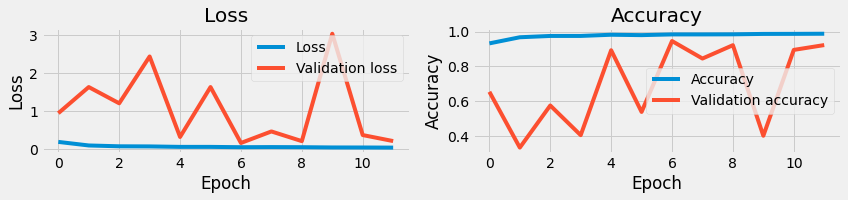

ROC AUC Score: 0.9383026120846928


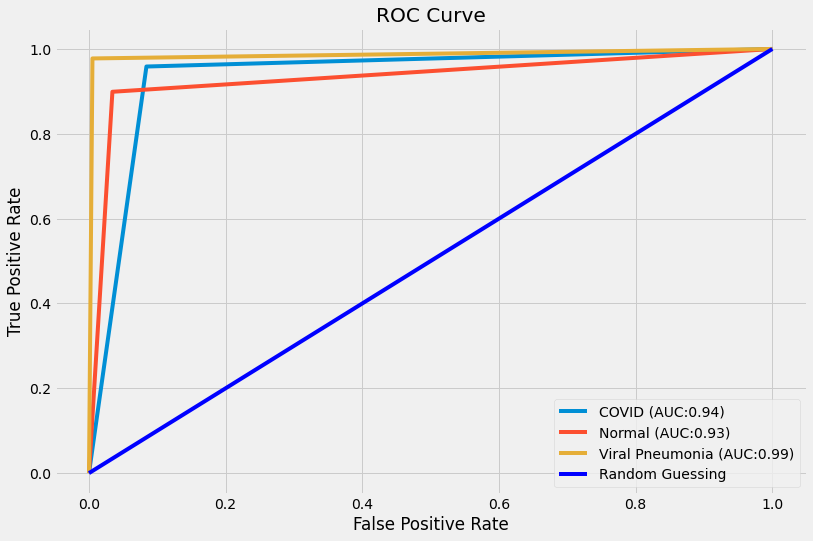

                 precision    recall  f1-score   support

          COVID       0.78      0.96      0.86       362
         Normal       0.98      0.90      0.94      1020
Viral Pneumonia       0.95      0.98      0.96       134

       accuracy                           0.92      1516
      macro avg       0.90      0.95      0.92      1516
   weighted avg       0.93      0.92      0.92      1516



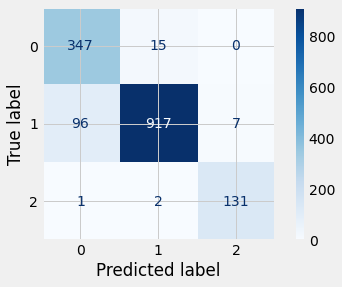

In [40]:
train_report(trained)
plot_history(trained)
multiclass_roc_auc_score(y_true.astype(int), y_pred)
print_report()
print_conf_mtx()